<a href="https://colab.research.google.com/github/rmonro12/Intro_to_ML/blob/main/Homework_Assignments/HW_7/Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ryan Monroe (801219572) - 12/02/2025 <br>
ECGR 4105 - Homework 7, Problem 1

In [ ]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import time
import datetime

In [ ]:
#Check if GPU is available for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


##Feature mapping

In [ ]:
# Define transformations for the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Download and load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Number of classes: {len(trainset.classes)}")
print(f"Classes: {trainset.classes}")

Training set size: 50000
Test set size: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Assuming a binary classification task is intended,
# where one specific class is considered 'positive' (label 1),
# and all other classes are considered 'negative' (label 0).
# Let's choose 'automobile' (class_id = 1) as the positive class for demonstration.
target_class_id = 1 # 'automobile'

# Function to convert multi-class labels to binary labels
def to_binary_label(labels, target_class_id):
    # Convert labels to 0 for 'not target_class_id' and 1 for 'target_class_id'
    return (labels == target_class_id).long()

# Extract all images and original labels from the training dataset
all_train_images = []
all_train_original_labels = []
for img, label in trainset:
    all_train_images.append(img)
    all_train_original_labels.append(label)

train_X_full = torch.stack(all_train_images)
train_Y_original_full = torch.tensor(all_train_original_labels, dtype=torch.long)

# Convert original labels to binary labels for the training process.
# The training loop expects continuous values for its regression loss,
# so we will use float type for train_Y and val_Y.
train_Y_binary_full = to_binary_label(train_Y_original_full, target_class_id).float()

print(f"Full training data X shape: {train_X_full.shape}, Y original shape: {train_Y_original_full.shape}, Y binary float shape: {train_Y_binary_full.shape}")

# Split the full training data into training and validation sets
from sklearn.model_selection import train_test_split

# We need to split X, the original Y labels (for val_Y_raw), and the binary Y labels (for training_loop Y)
# Convert to numpy for sklearn split, then back to torch tensors
train_X_np = train_X_full.numpy()
train_Y_original_np = train_Y_original_full.numpy()
train_Y_binary_np = train_Y_binary_full.numpy()

# Perform the split for X, original Y, and binary Y simultaneously
train_X, val_X, train_Y_original, val_Y_original, train_Y_binary, val_Y_binary = train_test_split(
    train_X_np, train_Y_original_np, train_Y_binary_np,
    test_size=0.2, random_state=42, stratify=train_Y_original_np # stratify based on original labels to maintain class distribution
)

# Convert back to torch tensors
train_X = torch.from_numpy(train_X)
val_X = torch.from_numpy(val_X)

# These Ys will be used for the training loop's regression loss
train_Y = torch.from_numpy(train_Y_binary).float()
val_Y = torch.from_numpy(val_Y_binary).float()

# val_Y_raw is needed for the metrics calculation cell (GrIfKVJh31p_)
# This should be the original (unstandardized, unbinarized) labels for the validation set.
val_Y_raw = torch.from_numpy(val_Y_original).long() # Keep as long for consistency with target classes

print(f"\nAfter splitting:")
print(f"train_X shape: {train_X.shape}, train_Y shape: {train_Y.shape} (binary float)")
print(f"val_X shape: {val_X.shape}, val_Y shape: {val_Y.shape} (binary float)")
print(f"val_Y_raw shape: {val_Y_raw.shape} (original long for metrics)")

# Define mu_Y and sigma_Y for consistency with cell GrIfKVJh31p_
# These are calculated from the *training portion* of the binary labels,
# assuming these were the values that might have been standardized before being used as targets.
mu_Y = train_Y.mean()
sigma_Y = train_Y.std()

print(f"mu_Y: {mu_Y.item():.4f}, sigma_Y: {sigma_Y.item():.4f}")

Full training data X shape: torch.Size([50000, 3, 32, 32]), Y original shape: torch.Size([50000]), Y binary float shape: torch.Size([50000])

After splitting:
train_X shape: torch.Size([40000, 3, 32, 32]), train_Y shape: torch.Size([40000]) (binary float)
val_X shape: torch.Size([10000, 3, 32, 32]), val_Y shape: torch.Size([10000]) (binary float)
val_Y_raw shape: torch.Size([10000]) (original long for metrics)
mu_Y: 0.1000, sigma_Y: 0.3000


##Network Construction

In [ ]:
# Define the neural network
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, n_input_features):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        # Adding a new convolutional layer, activation, and pooling
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act3_new = nn.Tanh() # Renamed to avoid conflict with existing act3
        self.pool3 = nn.MaxPool2d(2)
        # Recalculate input features for fc1 after adding pool3
        # Original: (32 / 2 / 2) = 8, so 8*8*8 features
        # New: (32 / 2 / 2 / 2) = 4, so 4*4*4 features * 4 output channels from conv3
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.act3 = nn.Tanh() # This was originally act3
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Ensure input x is float for nn.Linear
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        # Pass through the new layers
        out = self.pool3(self.act3_new(self.conv3(out))) # Use act3_new here
        out = out.view(-1, 4 * 4 * 4) # Adjust flattening to new dimensions
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
# Define loss function
import torch.nn.functional as F
def loss(Y_pred, Y):
  # Using BCEWithLogitsLoss for binary classification with logits
  return F.binary_cross_entropy_with_logits(Y_pred.squeeze(), Y)

##Training

In [ ]:
# Define training loop
def training_loop(n_epochs, optimizer, model_nn, loss_fn, train_loader):
  train_losses = [] # Initialize list to store training losses per epoch
  start_time = time.time() # Record start time
  for epoch in range(1, n_epochs + 1):
    current_epoch_loss = 0.0
    for imgs, labels in train_loader:
      #Move imgs & labels to training device (GPU if available)
      imgs = imgs.to(device)
      labels = labels.to(device)

      outputs = model_nn(imgs)
      batch_loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      current_epoch_loss += batch_loss.item()

    avg_epoch_loss = current_epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if epoch <= 3 or epoch % 10 == 0:
      print(f"Epoch {epoch}, Training loss {avg_epoch_loss:.4f}")
  end_time = time.time() # Record end time
  training_time_seconds = end_time - start_time # Calculate training time
  return model_nn, train_losses, training_time_seconds # Return the trained model, losses, and time

In [ ]:
# Perform training
import torch.utils.data
cifar2 = torch.utils.data.TensorDataset(train_X, train_Y)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model_nn = Net(3).to(device) # Initialize the neural network model
#model_nn.load_state_dict(torch.load('model.pth', map_location=device))
learning_rate = 0.01 # adjust learning rate to find sweet spot (0.01)
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)

model_nn, train_losses, training_time_seconds = training_loop(
    n_epochs = 300, # adjust epochs to find sweet spot (200)
    optimizer = optimizer,
    model_nn = model_nn, # pass the model instance
    loss_fn = loss, # Changed from nn.CrossEntropyLoss() to loss
    train_loader = train_loader)

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Total Training Time: {training_time_seconds:.2f} seconds")

Epoch 1, Training loss 0.3808
Epoch 2, Training loss 0.3228
Epoch 3, Training loss 0.3133
Epoch 10, Training loss 0.2217
Epoch 20, Training loss 0.1727
Epoch 30, Training loss 0.1526
Epoch 40, Training loss 0.1389
Epoch 50, Training loss 0.1280
Epoch 60, Training loss 0.1189
Epoch 70, Training loss 0.1112
Epoch 80, Training loss 0.1049
Epoch 90, Training loss 0.1002
Epoch 100, Training loss 0.0958
Epoch 110, Training loss 0.0912
Epoch 120, Training loss 0.0873
Epoch 130, Training loss 0.0839
Epoch 140, Training loss 0.0813
Epoch 150, Training loss 0.0781
Epoch 160, Training loss 0.0760
Epoch 170, Training loss 0.0739
Epoch 180, Training loss 0.0714
Epoch 190, Training loss 0.0697
Epoch 200, Training loss 0.0673
Epoch 210, Training loss 0.0659
Epoch 220, Training loss 0.0638
Epoch 230, Training loss 0.0627
Epoch 240, Training loss 0.0611
Epoch 250, Training loss 0.0597
Epoch 260, Training loss 0.0577
Epoch 270, Training loss 0.0563
Epoch 280, Training loss 0.0547
Epoch 290, Training los

##Validation

In [ ]:
# Perfrom validation
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

def validate(model_nn, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device) # Move images to the same device as the model
        labels = labels.to(device) # Move labels to the same device
        outputs = model_nn(imgs) # These are logits
        # Apply sigmoid to convert logits to probabilities, then threshold at 0.5
        predicted = (torch.sigmoid(outputs).squeeze() > 0.5).long()
        total += labels.shape[0]
        # Convert labels to long for comparison with predicted classes
        correct += int((predicted == labels.long()).sum())

    print(f"Accuracy {name} {correct/total:.2f}")

validate(model_nn, train_loader, val_loader)

Accuracy train 0.98
Accuracy val 0.98


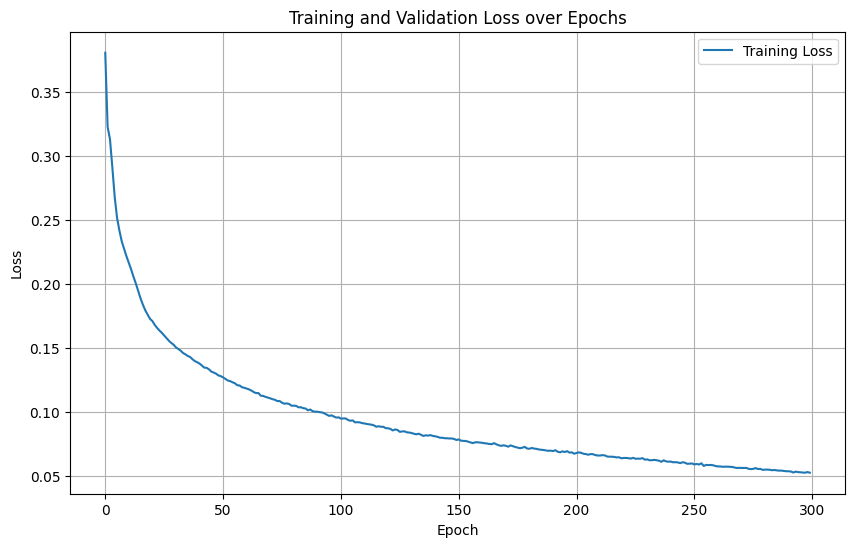

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Check performance characteristics

# Move val_X to the correct device
val_X_device = val_X.to(device)

# Get raw logits from the model
val_Y_pred_logits = model_nn(val_X_device).squeeze()

# Apply sigmoid to convert logits to probabilities
val_Y_pred_probabilities = torch.sigmoid(val_Y_pred_logits)

# Convert to binary classes using a threshold (e.g., 0.5)
predicted_classes = (val_Y_pred_probabilities > 0.5).long()

# Get the true binary labels for the validation set and move to device
# val_Y is already binary (0.0 or 1.0) float, convert to long for metrics
true_classes = val_Y.long().to(device)

# Convert to numpy arrays, detaching from computation graph
predicted_classes_np = predicted_classes.cpu().numpy()
true_classes_np = true_classes.cpu().numpy()

from sklearn import metrics
acc = metrics.accuracy_score(true_classes_np, predicted_classes_np)
pre = metrics.precision_score(true_classes_np, predicted_classes_np)
rec = metrics.recall_score(true_classes_np, predicted_classes_np)
F1 = metrics.f1_score(true_classes_np, predicted_classes_np)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision:  {pre:.3f}")
print(f"Recall:  {rec:.3f}")
print(f"F1 Score:  {F1:.3f}")

Accuracy:  0.954
Precision:  0.764
Recall:  0.780
F1 Score:  0.772
